##Key-Gen Code

In [ ]:
import random
from sympy import isprime, nextprime, factorint

SMALL_PRIMES = [2, 3, 5, 7, 11, 13, 17, 19]
# Generate a random kappa-bit prime
def random_prime_with_bits(kappa):
    low = 1 << (kappa - 1)
    high = (1 << kappa) - 1
    p = random.randrange(low, high)
    return nextprime(p)

# Find P such that P-1 has a kappa-bit prime factor
def find_prime_with_large_factor(kappa):
    while True:
        r = random_prime_with_bits(kappa)   # large prime factor
        m = random.randint(2, 100)         # small cofactor
        P = m * r + 1                        # ensures r | P−1
        if isprime(P):
            return P, r


def small_prime_factorization(n):
    """Return dictionary of exponents for primes < 20 in n."""
    result = {}
    for p in SMALL_PRIMES:
        count = 0
        while n % p == 0:
            n //= p
            count += 1
        if count > 0:
            result[p] = count
    return result   # ignore remaining large cofactor

# Compute k1 from ui, vi using your casework
def compute_k1(U, V, a, b):
    # U and V are dictionaries mapping prime p_i -> exponent ui/vi
    primes = sorted(set(U.keys()) | set(V.keys()))
    s_list=[]
    u_list=[]
    v_list=[]
    p_list=[]
    k1 = 1

    for p in primes:
        ui = U.get(p, 0)
        vi = V.get(p, 0)

        # Case 1: i >= 1 (i.e., prime != 2)
        if p != 2:
            si = max(ui, vi)

        # Case 2: p = 2 (special parity rules)
        else:
            if (a + b) % 2 == 0:
                si = max(ui, vi)
            elif (a % 2 == 0) and (b % 2 == 1):
                si = ui
            elif (a % 2 == 1) and (b % 2 == 0):
                si = vi
            else:
                si = max(ui, vi)
        s_list.append(si)
        u_list.append(ui)
        v_list.append(vi)
        p_list.append(p)
        k1 *= (p ** si)

    return k1, s_list, u_list, v_list, p_list

# Main function requested
def Key_gen(kappa, a, b):
    # Step 1: generate primes
    P, rP = find_prime_with_large_factor(kappa)
    Q, rQ = find_prime_with_large_factor(kappa)

    # Step 2: compute N
    N = (P ** a) * (Q ** b)

    # Step 3: factor P−1 and Q−1
    U = small_prime_factorization(P - 1)
    V = small_prime_factorization(Q - 1)


    # Step 4: compute k1 from ui, vi
    k1, s_list, u_list, v_list, p_list = compute_k1(U, V, a, b)

    # Step 5: compute final k
    k = k1 * (P ** (a - 1)) * (Q ** (b - 1))
    l = k.bit_length()
    K=N*k1
    y = sample_from_YNk(N, P, Q, a, b, s_list, u_list, v_list,p_list)
    return P, Q, N, rP, rQ, k1, k, s_list, v_list, u_list, p_list, l, K, y


In [ ]:
import random
from math import gcd

# Compute Jacobi symbol (y | n)
def jacobi(a, n):
    if n <= 0 or n % 2 == 0:
        raise ValueError("n must be a positive odd number.")
    a = a % n
    result = 1
    while a != 0:
        while a % 2 == 0:
            a //= 2
            if n % 8 in [3, 5]:
                result = -result

        a, n = n, a
        if a % 4 == 3 and n % 4 == 3:
            result = -result
        a %= n
    return result if n == 1 else 0


# -----------------------------------------------------------
# Check membership in YP
# -----------------------------------------------------------
def check_in_YP(y, P, a):
    if a == 1:
        # YP = {1}
        return y % P == 1
    # require y^(P-1) * P^(a-2) != 1 mod P^a
    return pow(y, (P - 1) * (P ** (a - 2)), P ** a) != 1


# -----------------------------------------------------------
# Check membership in YQ
# -----------------------------------------------------------
def check_in_YQ(y, Q, b):
    if b == 1:
        # YQ = {1}
        return y % Q == 1
    # require y^(Q-1) * Q^(b-2) != 1 mod Q^b
    return pow(y, (Q - 1) * (Q ** (b - 2)), Q ** b) != 1


# -----------------------------------------------------------
# Check membership in Y0 (special case)
# -----------------------------------------------------------
def check_in_Y0(y, N, P, Q, s0, u0, v0, p0):
    # Must satisfy Jacobi(y/N)=1 always
    if jacobi(y, N) != 1:
        return False

    if s0 == u0:
        # require (y | P) = -1
        return jacobi(y, P) == -1
    else:
        # s0 = v0
        # require (y | Q) = -1
        return jacobi(y, Q) == -1


# -----------------------------------------------------------
# Check membership in Yi for 1 ≤ i ≤ t
# -----------------------------------------------------------
def check_in_Yi(y, P, Q, si, ui, vi,pi):
    if si == ui:
        # require y^(P-1)/p_i != 1 mod P
        exp = (P - 1) // pi  # careful: ui = p_i^e, but si = exponent, you must supply p_i
        return pow(y, exp, P) != 1

    else:
        # si == vi
        exp = (Q - 1) // pi
        return pow(y, exp, Q) != 1


# -----------------------------------------------------------
# Main function: return y ∈ Y(N,k)
# -----------------------------------------------------------
def sample_from_YNk(N, P, Q, a, b, s_list, u_list, v_list,p_list):
    """
    s_list: [s0, s1, ..., st]
    u_list: [u0, u1, ..., ut]
    v_list: [v0, v1, ..., vt]
    """

    while True:
        y = random.randrange(2, N - 1)

        # Condition: gcd(y, N) = 1 (implicitly required)
        if gcd(y, N) != 1:
            continue

        # Check YP
        if not check_in_YP(y, P, a):
            continue

        # Check YQ
        if not check_in_YQ(y, Q, b):
            continue

        # Check Y0 special case
        if not check_in_Y0(y, N, P, Q, s_list[0], u_list[0], v_list[0],p_list[0]):
            continue

        # Check Yi for i ≥ 1
        ok = True
        for i in range(1, len(s_list)):
            if not check_in_Yi(y, P, Q, s_list[i], u_list[i], v_list[i],p_list[i]):
                ok = False
                break

        if not ok:
            continue

        return y


##Run Key-Gen

In [ ]:
kappa = 6
a=3
b=2
P, Q, N, rP, rQ, k1, k, s_list, v_list, u_list, p_list, l, K, y=Key_gen(kappa, a,b)
print(P, Q, N, rP, rQ, k1, k, s_list, v_list, u_list, p_list, l, K, y)
public_key=(N,y,l,K)
secret_key=(P,Q,k)

173 3527 64409396318693 43 41 2 211119166 [1] [1] [2] [2] 28 128818792637386 25835305559798


##Encoder Code

In [ ]:
import secrets
from math import gcd

def random_ZN_star(N):
    """Return a random x in Z*_N."""
    while True:
        x = secrets.randbelow(N)
        if 1 < x < N and gcd(x, N) == 1:
            return x

def encoder(public_key, m):
    """
    Input:
        public_key = (N, y, l, K)
        m : integer message 0 <= m < 2^(l-1)
    Output:
        ciphertext c = y^m * x^K mod N
    """
    N, y, l, K = public_key

    # Check message length requirement
    if m < 0 or m >= 2**(l - 1):
        raise ValueError(f"Message must be in range [0, 2^(ell-1)-1]. Got m = {m}")

    # 1. Sample x from Z*_N
    x = random_ZN_star(N)

    # 2. Compute ciphertext
    c = (pow(y, m, N) * pow(x, K, N)) % N

    return c


##Run Encoder

In [ ]:
m = 10000
c=encoder(public_key,m)
print(c)

3029173514140


##Decoder Code

In [ ]:


from math import isqrt
from functools import reduce
from typing import List, Tuple
import math

# ---------- helpers ----------
def egcd(a, b):
    if b == 0:
        return (a, 1, 0)
    g, x1, y1 = egcd(b, a % b)
    return (g, y1, x1 - (a // b) * y1)

def inv_mod(a, m):
    g, x, _ = egcd(a, m)
    if g != 1:
        raise ValueError(f"No inverse for {a} mod {m}, gcd={g}")
    return x % m

def crt_combine_lists(residues: List[int], moduli: List[int]) -> Tuple[int,int]:
    """Combine residues (r_i mod n_i) into x mod N where N = prod n_i."""
    if len(residues) != len(moduli):
        raise ValueError("length mismatch")
    N = 1
    for n in moduli:
        N *= n
    x = 0
    for r, n in zip(residues, moduli):
        M = N // n
        inv = inv_mod(M, n)
        x = (x + (r * M * inv)) % N
    return x, N

# ---------- SDLP1: small subgroup solver ----------
def SDLP1(c_i: int, y_i: int, order: int, prime: int) -> int:
    """
    Solve y_i^m = c_i (mod prime), where order = p^s is small.
    Uses baby-step giant-step but falls back to brute force if order tiny.
    Returns m in [0, order-1].
    """
    # Quick brute-force for very small orders
    if order <= 1000:
        cur = 1
        for m in range(order):
            if cur == c_i % prime:
                return m
            cur = (cur * y_i) % prime
        raise ValueError("SDLP1 brute-force failed")
    # BSGS otherwise
    m = int(isqrt(order)) + 1
    baby = {}
    cur = 1
    for j in range(m):
        if cur not in baby:
            baby[cur] = j
        cur = (cur * y_i) % prime
    # compute y_i^{-m}
    inv_y = pow(y_i, -1, prime)  # python supports modular inverse if gcd=1
    factor = pow(inv_y, m, prime)
    gamma = c_i % prime
    for k in range(m+1):
        if gamma in baby:
            return (k * m + baby[gamma]) % order
        gamma = (gamma * factor) % prime
    raise ValueError("SDLP1 BSGS failed")

# ---------- corrected decrypt_part1 ----------
def decrypt_part1(c: int, P: int, Q: int, y: int,
                  prime_list: List[int], exponent_list: List[int]):
    """
    For each small prime p_i and exponent s_i compute m_i = m mod p_i^s_i
    according to the paper:
      if p_i^s_i | (P-1) compute c_i = c^{(P-1)/p_i^s_i} mod P, y_i = y^{(P-1)/p_i^s_i} mod P
      else if p_i^s_i | (Q-1) compute the same with Q
      else raise error (parameters inconsistent)
    Then combine {m_i} by CRT to get m mod k1 where k1 = product p_i^s_i.
    Returns (m_k1, k1).
    """

    if len(prime_list) != len(exponent_list):
        raise ValueError("prime_list and exponent_list must align")

    residues = []
    moduli = []

    for (p_i, s_i) in zip(prime_list, exponent_list):
        modulus_pi = p_i ** s_i

        # decide which prime side this small prime-power divides
        divides_P = ((P - 1) % modulus_pi == 0)
        divides_Q = ((Q - 1) % modulus_pi == 0)

        if divides_P and divides_Q:
            # Rare: both sides divisible; the paper's scheme normally ensures
            # a defined choice; choose P by convention or raise a warning.
            side = 'P'  # choose P by convention
            prime_side = P
            exp = (P - 1) // modulus_pi
        elif divides_P:
            side = 'P'
            prime_side = P
            exp = (P - 1) // modulus_pi
        elif divides_Q:
            side = 'Q'
            prime_side = Q
            exp = (Q - 1) // modulus_pi
        else:
            raise ValueError(f"p_i^{s_i} = {modulus_pi} divides neither P-1 nor Q-1; inconsistent inputs.")

        # compute reduced values modulo the chosen prime
        c_i = pow(c, exp, prime_side)
        y_i = pow(y, exp, prime_side)

        # verify order assumption (optional but recommended)
        if pow(y_i, modulus_pi, prime_side) != 1:
            # This means y_i does not have the expected order; either inputs or y are invalid.
            # We can still try to proceed, but it's likely to fail.
            raise ValueError(f"y_i^{modulus_pi} != 1 mod {prime_side}; order assumption violated for p={p_i}")

        # solve small-subgroup discrete log
        m_i = SDLP1(c_i, y_i, modulus_pi, prime_side) % modulus_pi

        residues.append(m_i)
        moduli.append(modulus_pi)

    # combine via CRT
    m_k1, k1 = crt_combine_lists(residues, moduli)
    return m_k1


In [ ]:
mk1 = decrypt_part1(c, P,Q, y, p_list, s_list)
print(mk1)

0


In [ ]:
import math

def solve_dlp_brute_force(a, b, p):
    """
    Solves the discrete logarithm problem a^z = b (mod p) by brute force.
    Assumes p is prime and gcd(a, p) = 1.
    """
    for z in range(p - 1):
        if pow(a, z, p) == b % p:
            return z
    return "No solution found in the range [0, p-2]"

def discrete_log_lift(a, z, b, p, k):
    m = pow(p, k)
    z = z % (p - 1)
    a = a % m
    b = b % m
    c = pow(a, z, m)
    y = 0

    if p == 2:
        u = 2
        e = pow(a, 2, m)
    else:
        u = 1
        e = pow(a, p - 1, m)

    h = e - 1
    r = 0

    while h % p == 0 and r < k:
        h = h // p
        r = r + 1

    v = pow(p, r)

    if (b - c) % v != 0:
        if p > 2 or (b - a) % v != 0:
            return None
        c = a
        y = 1

    g = pow(h * b, p - 2, p)

    while b != c:
        d = (g * ((b - c) // v)) % p
        y = y + d * u

        if r + r >= k:
            f = (1 + (e - 1) * d) % m
            e = (1 + (e - 1) * p) % m
        else:
            f = pow(e, d, m)
            e = (f * pow(e, p - d, m)) % m

        c = (c * f) % m
        u = u * p
        v = v * p
        r = r + 1

    return (p - 1) * y + z

def SDLP2(c, y, P, a):
    """
    Solve discrete log c ≡ y^m (mod P^a) where ord_{P^a}(y) = P^(a-1).
    Inputs:
        c, y : integers (mod P^a)
        P    : prime base (integer)
        a    : integer exponent >= 2
    Output:
        m in [0, P^(a-1)-1] such that c ≡ y^m (mod P^a)
    Note:
        This implements the recursive algorithm outlined in Algorithm 2
        of the paper (special base case for a == 2, recursion otherwise).
    """
    # --- sanitize types (force native Python ints) ---
    z=solve_dlp_brute_force(y, c, P)
    m=discrete_log_lift(y, z, c, P, a)

    return m


def compute_mP(c, y, P, a):
    """
    Compute m_P from:
      c_P = c^(P-1) mod P^a
      y_P = y^(P-1) mod P^a
    Solve c_P ≡ y_P^m_P (mod P^a)
    where ord_P(y_P) = P^(a-1)
    """
    if a <= 1:
        return 0  # No m_P component if a=1

    modulus = P ** a
    #order = P ** (a - 1)

    cP = pow(c, P - 1, modulus)
    yP = pow(y, P - 1, modulus)

    mP = SDLP2(cP, yP, P, a)
    return mP


def compute_mQ(c, y, Q, b):
    """
    Same for Q-side if b>1.
    """
    if b <= 1:
        return 0

    modulus = Q ** b
    #order = Q ** (b - 1)

    cQ = pow(c, Q - 1, modulus)
    yQ = pow(y, Q - 1, modulus)

    mQ = SDLP2(cQ, yQ, Q, b)
    return mQ


In [ ]:
a=3
b=2
mP = compute_mP(c, y, P, a)
mQ = compute_mQ(c, y, Q, b)
print(mP,mQ)

4439492 2048606


In [ ]:
def crt_pair(a1, n1, a2, n2):
    """
    Solve the system:
         x ≡ a1 (mod n1)
         x ≡ a2 (mod n2)
    using standard CRT.
    Returns (x, n1*n2).
    """

    # Compute inverse of n1 modulo n2
    inv = pow(n1, -1, n2)
    x = (a1 + (a2 - a1) * inv % n2 * n1) % (n1 * n2)
    return x, n1 * n2


def crt_list(residues, moduli):
    """
    Apply CRT sequentially over lists.
    residues = [r1, r2, r3, ...]
    moduli   = [n1, n2, n3, ...]

    Returns (x, N) where:
        x = solution mod N
        N = product of moduli
    """
    x, N = residues[0], moduli[0]
    for r, n in zip(residues[1:], moduli[1:]):
        x, N = crt_pair(x, N, r, n)
    return x, N


def combine_message(mk1, mP, mQ, k1, P, a, Q, b):
    """
    Computes the final m using CRT:
        m ≡ mk1 mod k1
        m ≡ mP mod P^(a-1)
        m ≡ mQ mod Q^(b-1)
    """
    modP = P ** (a - 1) if a > 1 else 1
    modQ = Q ** (b - 1) if b > 1 else 1

    residues = [mk1]
    moduli   = [k1]

    if modP > 1:
        residues.append(mP)
        moduli.append(modP)

    if modQ > 1:
        residues.append(mQ)
        moduli.append(modQ)

    m, k = crt_list(residues, moduli)
    return m % k


In [ ]:
m_final = combine_message(mk1, mP, mQ, k1, P, a, Q, b)
print(m_final)

10000


In [ ]:
def decoder(private_key, c, a, b, y, k1, p_list, s_list):
    """
    Input:
        private_key = (P, Q, y, a

    Output:
        message m
    """
    P, Q, k = private_key
    mk1 = decrypt_part1(c, P,Q, y, p_list, s_list)
    mP = compute_mP(c, y, P, a)
    mQ = compute_mQ(c, y, Q, b)
    m_final = combine_message(mk1, mP, mQ, k1, P, a, Q, b)
    return m_final


##Run Decoder

In [ ]:
print(decoder(secret_key,c,a,b,y,k1,p_list,s_list))


10000


##Experiments on Generalised GM

   Keygen_time_ms  Enc_time_ms  Dec_time_ms  a  b  empirical_r  theoretical_r  \
0        0.157118     0.036478     0.054598  2  2     1.750000       1.846154   
1        0.306845     0.031948     0.067234  2  3     1.447368       1.410256   
2        0.214100     0.047922     0.060081  2  4     1.313725       1.296296   
3        0.117779     0.031471     0.052691  3  2     1.351351       1.475000   
4        0.197887     0.030756     0.055075  3  3     1.292683       1.266667   
5        0.216246     0.054836     0.068903  3  4     1.276923       1.257143   
6        0.387430     0.045300     0.067711  4  2     1.178571       1.241379   
7        0.260115     0.051737     0.072956  4  3     1.238095       1.227273   
8        0.215054     0.061750     0.074387  4  4     1.181818       1.176471   

   P_bits  Q_bits  k_bits  cipher_bits  
0      12      12      25           42  
1      11      11      39           55  
2      13      11      52           67  
3      13      10      38

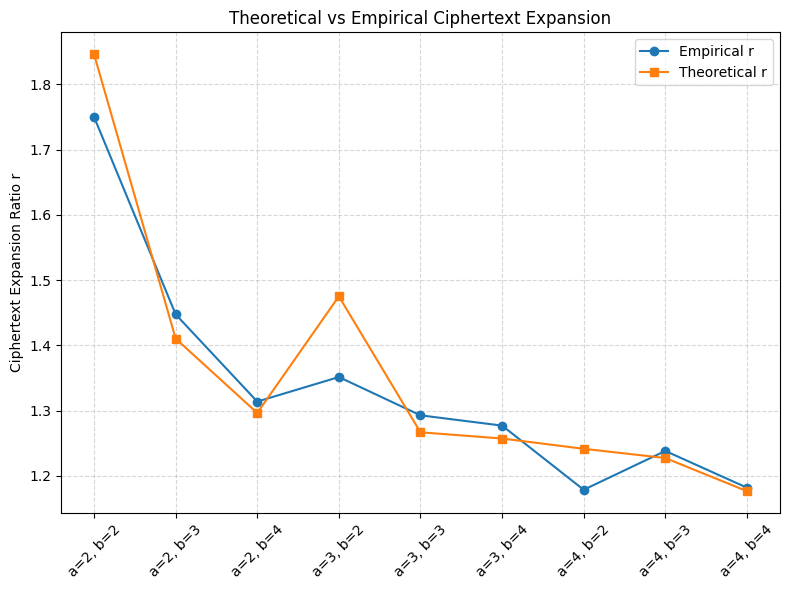

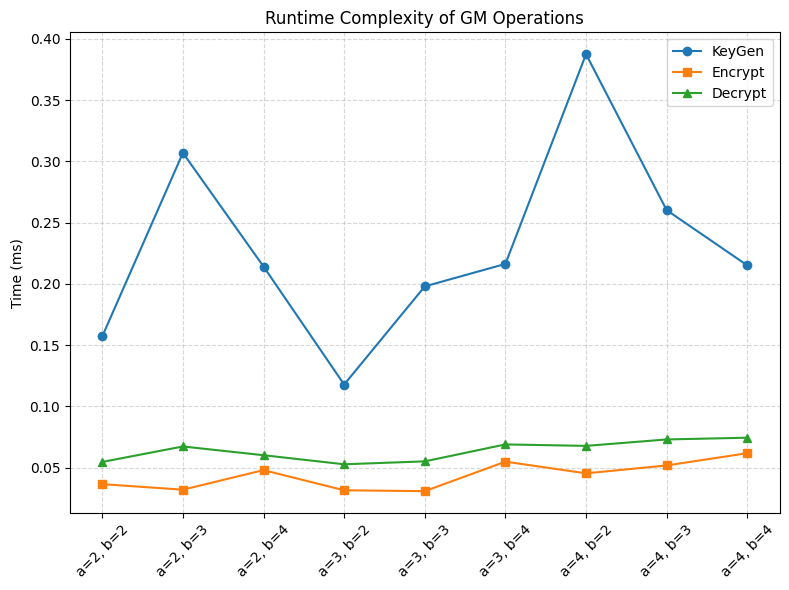

In [ ]:
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from secrets import randbelow
import random

def bitlen(x):
    return x.bit_length()


# -----------------------------------------------------
# Run a single experiment (one parameter set)
# -----------------------------------------------------
def run_experiment(a, b, kappa=6):
    results = {}

    # -------------------------
    # 1. Key generation
    # -------------------------
    t0 = time.time()
    P, Q, N, rP, rQ, k1, k, s_list, v_list, u_list, p_list, l, K, y = Key_gen(kappa, a, b)
    t1 = time.time()
    results["Keygen_time_ms"] = (t1 - t0) * 1000

    # lengths
    lP = bitlen(P)
    lQ = bitlen(Q)
    l1 = bitlen(k1)

    # -------------------------
    # 2. Encryption
    # -------------------------
    m = sum(random.randrange(k) for _ in range(100)) // 100
    public_key = (N, y, l, K)

    t0 = time.time()
    c = encoder(public_key, m)
    t1 = time.time()
    results["Enc_time_ms"] = (t1 - t0) * 1000

    # -------------------------
    # 3. Decryption
    # -------------------------
    secret_key = (P, Q, k)

    t0 = time.time()
    _ = decoder(secret_key, c, a, b, y, k1, p_list, s_list)
    t1 = time.time()
    results["Dec_time_ms"] = (t1 - t0) * 1000

    # -------------------------
    # 4. Ratios
    # -------------------------
    emp_r = bitlen(c) / bitlen(m)
    th_r = (a * lP + b * lQ) / ((a - 1) * lP + (b - 1) * lQ + l1)

    results["a"] = a
    results["b"] = b
    results["empirical_r"] = emp_r
    results["theoretical_r"] = th_r
    results["P_bits"] = lP
    results["Q_bits"] = lQ
    results["k_bits"] = bitlen(k)
    results["cipher_bits"] = bitlen(c)

    return results


# -----------------------------------------------------
# MASTER: sweep multiple parameter sets
# -----------------------------------------------------
def run_full_study():
    experiments = []

    for a in [2, 3, 4]:
        for b in [2, 3, 4]:
            res = run_experiment(a, b)
            experiments.append(res)

    df = pd.DataFrame(experiments)
    return df


# -----------------------------------------------------
# Plot: Theoretical vs Empirical Ciphertext Expansion
# -----------------------------------------------------
def plot_cipher_expansion(df):
    plt.figure(figsize=(8, 6))

    x = range(len(df))
    labels = [f"a={A}, b={B}" for A, B in zip(df["a"], df["b"])]

    plt.plot(x, df["empirical_r"], label="Empirical r", marker="o")
    plt.plot(x, df["theoretical_r"], label="Theoretical r", marker="s")

    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Ciphertext Expansion Ratio r")
    plt.title("Theoretical vs Empirical Ciphertext Expansion")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------
# Plot: Runtime (KeyGen, Enc, Dec)
# -----------------------------------------------------
def plot_runtime(df):
    plt.figure(figsize=(8, 6))

    x = range(len(df))
    labels = [f"a={A}, b={B}" for A, B in zip(df["a"], df["b"])]

    plt.plot(x, df["Keygen_time_ms"], label="KeyGen", marker="o")
    plt.plot(x, df["Enc_time_ms"], label="Encrypt", marker="s")
    plt.plot(x, df["Dec_time_ms"], label="Decrypt", marker="^")

    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Time (ms)")
    plt.title("Runtime Complexity of GM Operations")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------
# Run everything
# -----------------------------------------------------
df = run_full_study()
print(df)

plot_cipher_expansion(df)
plot_runtime(df)
